# Personalized Medicine: Redefining Cancer Treatment
Predict the effect of Genetic Variants to enable Personalized Medicine

- Basic Model implementation

# 1)- Import key Modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
# For ML Model and Evaluation
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [4]:
%reload_ext version_information
%version_information numpy, pandas, matplotlib

Software versions
Python 3.7.5 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.10.2
OS Darwin 19.3.0 x86_64 i386 64bit
numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
Sun Mar 22 16:05:06 2020 CET

# 2)-Loading Data

In [5]:
df_variant=pd.read_csv('training_variants')
df_variant.shape

(3321, 4)

In [6]:
df_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
df_variant.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


deescibe() is only useful for numerical data analysis. With class i.e categorical variable, we wont get much useful information

In [8]:
df_variant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [9]:
df_variant.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

### Checking target variable

In [10]:
df_variant.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

So we have a multi class problem

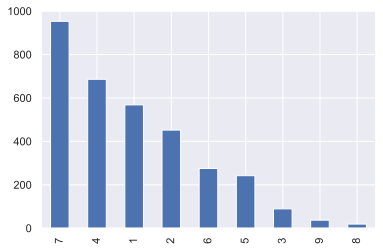

In [11]:
df_variant.Class.value_counts().plot(kind="bar")

In [12]:
df_variant.Class.value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

### Loading other dataset

In [13]:
df_text=pd.read_csv('training_text',sep='\|\|', engine='python', names=["ID","TEXT"], skiprows=1)
df_text.shape

(3321, 2)

In [14]:
df_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# 3)- Data Exploring

In [15]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [16]:
df_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

### 3.1)- Dealing with Missing Values

As ID is same so, we can merge these two datasets

In [17]:
# to see what are those missing values and at what ID they occur
df_text[df_text.TEXT.isnull()]

,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [18]:
df_text2=df_text.fillna('Other')

In [19]:
df_text2.isnull().sum()

ID      0
TEXT    0
dtype: int64

In [20]:
df_text2[df_text2.TEXT=="Other"]

,ID,TEXT
1109,1109,Other
1277,1277,Other
1407,1407,Other
1639,1639,Other
2755,2755,Other


So we successfully filled values with "Other" string

In [21]:
df_text2.shape

(3321, 2)

### 3.2)- Merging two datasets

In [22]:
df_merge=pd.merge(df_variant, df_text2, on='ID')
df_merge.shape

(3321, 5)

In [23]:
df_merge.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [24]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3321 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [25]:
len(df_merge.Gene.unique())

264

In [26]:
len(df_merge.Variation.unique())

2996

In [27]:
len(df_merge.Class.unique())

9

# 4)- Round 1 for Modeling

### 4.1)- Define Dependent and Independent variables

In [28]:
# define X and y
X = df_merge["TEXT"]
y = df_merge["Class"]

In [29]:
print(X.shape)
print(y.shape)

(3321,)
(3321,)


In [30]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2490,)
(831,)
(2490,)
(831,)


### 4.2)- Vectorize

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [33]:
# fit and transform X_train
X_train_dtm = vect.fit_transform(X_train)

In [34]:
# only transform X_test
X_test_dtm = vect.transform(X_test)

In [35]:
# examine the shapes: rows are documents, columns are terms (aka "tokens" or "features")
print(X_train_dtm.shape)
print(X_test_dtm.shape)

(2490, 137275)
(831, 137275)


In [36]:
# examine the last 50 features
print(vect.get_feature_names()[-50:])

['μˆi', 'μℳ', 'ρi', 'σ2', 'σ2a', 'σa', 'σfobs', 'σhkl', 'σhklfobs', 'σhσi', 'σhσiih', 'σi', 'σiσi', 'σj', 'σˆ2', 'σˆ2a', 'τrot', 'τtrans', 'φ80dlacz', 'φd', 'φx', 'φxxφφ', 'χ1', 'χ2', 'χ24', 'χ²', 'ψ0', 'ψ2', 'ψk', 'ψkxd', 'ψkxe', 'ψkxexxsp', 'ψψ', 'ϕa', 'ϕb', 'ϕnx', 'ϕx', 'ϕx174', 'ϕϕ', 'ϭϭϯ', 'ϵ280', 'ϵc', 'ϵr', 'сϭ', 'ⅱxl', 'ﬁbroblasts', 'ﬁlter', 'ﬁndings', 'ﬁxed', 'ﬂanks']


In [37]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### 4.3)- Naive Bayes Model

In [40]:
# use Multinomial Naive Bayes to predict the Classes
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

In [41]:
y_pred_class[:5]

array([1, 7, 1, 7, 4])

### 4.4)- Evaluation

In [42]:
# calculate null accuracy for 7 class type
y_test.value_counts().head(1) / y_test.shape

7    0.300842
Name: Class, dtype: float64

In [43]:
# print the accuracy of its predictions
from sklearn import metrics
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

Accuracy:  0.5896510228640193


In [44]:
# print the classification report
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.50      0.61      0.55       142
           2       0.43      0.45      0.44       117
           3       0.61      0.41      0.49        27
           4       0.77      0.54      0.63       170
           5       0.33      0.48      0.39        50
           6       0.70      0.57      0.63        61
           7       0.68      0.72      0.70       250
           8       1.00      0.20      0.33         5
           9       0.73      0.89      0.80         9

    accuracy                           0.59       831
   macro avg       0.64      0.54      0.55       831
weighted avg       0.61      0.59      0.59       831



# 5)- Round 2 : Modeling with Cross Validation 

### 4.1)- Define Dependent and Independent variables

In [45]:
# define X and y
X = df_merge["TEXT"]
y = df_merge["Class"]

In [46]:
print(X.shape)
print(y.shape)

(3321,)
(3321,)


### 4.2)- Vectorize

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

### 4.3)- Instantiate ML Model

In [48]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

### 4.4) Make NLP Pipeline

In [49]:
# create a pipeline of vectorization and Naive Bayes
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect, nb)

In [50]:
# examine the pipeline steps
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

### 4.5)- Applying Cross-Validation

In [51]:
# cross-validate the entire pipeline
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.36721491563297937

# 5)- Combining GridSearchCV with Pipeline

In [52]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['countvectorizer', 'multinomialnb'])

In [53]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

In [54]:
# pass the pipeline (instead of the model) to GridSearchCV
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [55]:
# time the grid search
%time grid.fit(X, y)

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 3min 5s, sys: 2.02 s, total: 3min 7s
Wall time: 2min 57s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

In [56]:
grid.cv_results_

{'mean_fit_time': array([12.56771646, 11.89287705,  0.60772705,  0.62099218]),
 'std_fit_time': array([0.59130828, 0.21334464, 0.01275067, 0.01420377]),
 'mean_score_time': array([3.27920198, 3.20289879, 0.15081096, 0.15496163]),
 'std_score_time': array([0.22861072, 0.2081874 , 0.01039879, 0.01022237]),
 'param_countvectorizer__token_pattern': masked_array(data=['\\b\\w\\w+\\b', '\\b\\w\\w+\\b', "'([a-z ]+)'",
                    "'([a-z ]+)'"],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_multinomialnb__alpha': masked_array(data=[0.5, 1, 0.5, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'countvectorizer__token_pattern': '\\b\\w\\w+\\b',
   'multinomialnb__alpha': 0.5},
  {'countvectorizer__token_pattern': '\\b\\w\\w+\\b',
   'multinomialnb__alpha': 1},
  {'countvectorizer__token_pattern': "'([a-z ]+)'",
   'multinomialnb__alpha': 0.5},
  {'countvect

In [57]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.3670581150255947
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'multinomialnb__alpha': 1}


We need alot to do with our data i.e feature engineering, model selection, better functional NLP pipeline.

For now, we have a better results in Round 1 and Round 2 in strive to improve model, we have got worse results. But,this is just start.

# END Of NOTEBOOK1